In [1]:
!pip install python-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.4 MB/s eta 0:00:00


# Importation du dataset

In [9]:
import pandas as pnd
import json
import re

In [4]:
df = pnd.read_csv("pokemon.csv",encoding="utf-8")

# Replaces the NULL values with the value from the previous row
df = df.ffill()

In [5]:
df.head()

,annotation_id,annotator,created_at,id,label,lead_time,text,updated_at
0,2,1,2025-03-10T15:00:25.920387Z,2,"[{""start"":3,""end"":10,""text"":""Pikachu"",""labels""...",825.900,1. Pikachu used Thunderbolt to defeat the wild...,2025-03-19T23:00:29.227096Z
1,46,1,2025-03-10T15:15:21.035367Z,3,"[{""start"":29,""end"":37,""text"":""Charzard"",""label...",499.897,2. Ash's favorite Pokémon is Charzard because ...,2025-03-19T23:00:26.568715Z
2,49,1,2025-03-10T15:17:41.093148Z,4,"[{""start"":13,""end"":16,""text"":""and"",""labels"":[""...",155.686,3. Bulbasaur and Squirtl teamed up to battle a...,2025-03-19T23:00:24.574354Z
3,47,1,2025-03-10T15:15:32.087001Z,5,"[{""start"":32,""end"":36,""text"":""Eeve"",""labels"":[...",194.099,"4. Team Rocket tried to capture Eeve, but it q...",2025-03-19T23:00:21.741442Z
4,48,1,2025-03-10T15:15:41.776349Z,6,"[{""start"":3,""end"":9,""text"":""Snorlx"",""labels"":[...",168.917,"5. Snorlx blocked the road, forcing the traine...",2025-03-19T23:00:19.152637Z


In [6]:
#Extract unique sentences
sentences = list(set(df["text"].values))

In [7]:
n_sentences = len(sentences)
print(n_sentences)

50


In [21]:
def extract_all_labels(df):
    dataset = []

    for _, row in df.iterrows():
        text = row["text"]
        labels = json.loads(row["label"])

        # Stocker toutes les annotations
        word_annotations = {}

        for label in labels:
            start, end = label["start"], label["end"]
            entity_label = label["labels"][0]  # Ex: "B-Pokemon", "B-Move", etc.

            first = True
            for match in re.finditer(r"\b\w+\b", text[start:end]):
                word_start = start + match.start()
                if first:
                    word_annotations[word_start] = entity_label  # "B-..." (début)
                    first = False
                else:
                    word_annotations[word_start] = "I-" + entity_label.split("-")[-1]  # "I-..."

        # Construire la séquence de tokens avec annotations
        word_tags = []
        words = re.finditer(r"\b\w+\b", text)

        for match in words:
            start = match.start()
            word = match.group()

            # Récupérer l'étiquette si elle existe, sinon "O"
            tag = word_annotations.get(start, "O")

            word_tags.append((word, tag))

        dataset.append(word_tags)

    return dataset


In [14]:
pip install sklearn_crfsuite

In [26]:
import sklearn_crfsuite
from sklearn_crfsuite import CRF
from sklearn.model_selection import train_test_split

# Transformation des mot en features
def word2features(sentence, i):
    word = sentence[i][0]
    features = {
        'word.lower()': word.lower(),
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word_prev = sentence[i - 1][0]
        features.update({
            '-1:word.lower()': word_prev.lower(),
            '-1:word.istitle()': word_prev.istitle(),
            '-1:word.isupper()': word_prev.isupper(),
        })
    else:
        features['BOS'] = True  # Début de phrase

    if i < len(sentence) - 1:
        word_next = sentence[i + 1][0]
        features.update({
            '+1:word.lower()': word_next.lower(),
            '+1:word.istitle()': word_next.istitle(),
            '+1:word.isupper()': word_next.isupper(),
        })
    else:
        features['EOS'] = True  # Fin de phrase

    return features

# Extraction des features
def extract_features(sentences):
    return [[word2features(s, i) for i in range(len(s))] for s in sentences]

# Extraction des labels
def extract_labels(sentences):
    return [[label for _, label in s] for s in sentences]

annotated_data = extract_all_labels(df)

X = extract_features(annotated_data)
y = extract_labels(annotated_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Séparation du dataset en train_test

# Entraînement du modèle CRF
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

# Sauvegarde du modèle
import pickle
with open("pokemon_crf_model.pkl", "wb") as f:
    pickle.dump(crf, f)

print("Modèle CRF entraîné et sauvegardé.")


Modèle CRF entraîné et sauvegardé.


In [27]:
import pickle

with open("pokemon_crf_model.pkl", "rb") as f:
    crf = pickle.load(f)

In [31]:
from sklearn_crfsuite import metrics

y_pred = crf.predict(X_test)

# Calcul du score F1
print(metrics.flat_classification_report(y_test, y_pred, labels=["B-Pokemon", "I-Pokemon", "B-Move", "B-Verb", "I-Verb", "0"]))


              precision    recall  f1-score   support

   B-Pokemon       0.83      0.91      0.87        11
   I-Pokemon       0.00      0.00      0.00         1
      B-Move       0.00      0.00      0.00         1
      B-Verb       0.86      0.43      0.57        14
      I-Verb       0.00      0.00      0.00         5
           0       0.82      0.97      0.89        64

   micro avg       0.81      0.81      0.81        96
   macro avg       0.42      0.38      0.39        96
weighted avg       0.76      0.81      0.77        96



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
test_sentence = [("Bulbasaur", "O"), ("uses", "O"), ("Vine", "O"), ("Whip", "O")]

# Extraire les features du test
X_new = [word2features(test_sentence, i) for i in range(len(test_sentence))]

# Prédiction
y_pred = crf.predict([X_new])

# Affichage des résultats
for word, label in zip([w[0] for w in test_sentence], y_pred[0]):
    print(f"{word}: {label}")

Bulbasaur: B-Pokemon
uses: 0
Vine: 0
Whip: 0


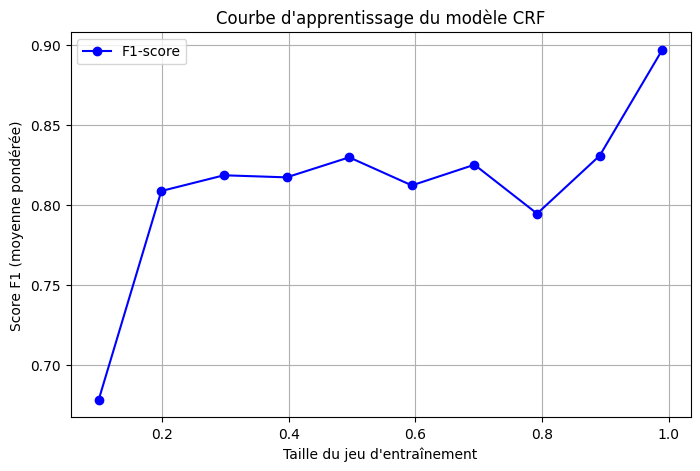

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF, metrics

def plot_learning_curve(X, y):
    train_sizes = np.linspace(0.1, 0.99, 10)  # 10 niveaux de fraction de données
    f1_scores = []

    for size in train_sizes:
        # Séparer en train/test avec une fraction des données
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, random_state=42)

        # Initialiser et entraîner le CRF
        crf = CRF(
            algorithm='lbfgs',
            c1=0.1, c2=0.1,
            max_iterations=100,
            all_possible_transitions=True
        )
        crf.fit(X_train, y_train)

        # Prédictions sur le jeu de test
        y_pred = crf.predict(X_test)

        # Calcul du F1-score sur toutes les classes
        f1 = metrics.flat_f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

    # 📊 Affichage de la courbe
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, f1_scores, marker='o', linestyle='-', color='b', label="F1-score")
    plt.xlabel("Taille du jeu d'entraînement")
    plt.ylabel("Score F1 (moyenne pondérée)")
    plt.title("Courbe d'apprentissage du modèle CRF")
    plt.legend()
    plt.grid(True)
    plt.show()

# ⚡️ Lancer la courbe d'apprentissage
plot_learning_curve(X, y)
